## Handling cellspace

##### 1. Create a cellspace

In [27]:
from complexity.cellspace import cellspace
cs_switzerland = cellspace(id = 'rectangle_Switzerland',
                           lat_min = 45.52084813133491, 
                           lat_max = 47.85, 
                           lon_min = 5.85392, 
                           lon_max = 10.80539976710652, 
                           alt_min = 18000, 
                           alt_max = 60000,
                           )

##### 2. Fetch data inside cellspace

In [28]:
cs_switzerland.get_data(start_date = '2019-01-01',
                          end_date = '2019-12-31')

Fetching data...
Combining data...


  0%|          | 0/12 [00:00<?, ?it/s]

##### 3. Preprocess fetched data

In [29]:
cs_switzerland.preprocess_data()

Preprocessing data in monthly chuks...


  0%|          | 0/12 [00:00<?, ?it/s]

Combining preprocessed data...


##### 4. Generate the grid

In [30]:
cs_switzerland.generate_cells()
cs_switzerland.visualise_cells()

Grid:
-----------------------------


Vertical ranges:
-----------------------------
Range 14 -> 57000ft - 60000ft
Range 13 -> 54000ft - 57000ft
Range 12 -> 51000ft - 54000ft
Range 11 -> 48000ft - 51000ft
Range 10 -> 45000ft - 48000ft
Range 09 -> 42000ft - 45000ft
Range 08 -> 39000ft - 42000ft
Range 07 -> 36000ft - 39000ft
Range 06 -> 33000ft - 36000ft
Range 05 -> 30000ft - 33000ft
Range 04 -> 27000ft - 30000ft
Range 03 -> 24000ft - 27000ft
Range 02 -> 21000ft - 24000ft
Range 01 -> 18000ft - 21000ft


##### 5. Split traffic to cells

In [31]:
cs_switzerland.assign_cell_traffic()

## Handling airspace

In [32]:
from operator import attrgetter
from traffic.data import nm_airspaces
from complexity.airspace import airspace

ge_uac = max(
    nm_airspaces.query('type == "CS" and designator.str.startswith("LSAGUAC")'),
    key=attrgetter("area"),  # equivalent to `lambda x: x.area`
)

In [33]:
geneva_uac = airspace(id = 'Geneva UAC', airspace = ge_uac)

In [34]:
geneva_uac.assign_cells(cellspace = cs_switzerland)

In [35]:
geneva_uac.visualise_cells()

In [ ]:
genevatraffic = geneva_uac.get_combined_traffic()

In [ ]:
from ipyleaflet import Map

m = Map(zoom=8, center=(49, -2))
for flight in genevatraffic[0:300]:
    m.add_layer(flight)

m

In [12]:
trajs = genevatraffic

In [13]:
df = trajs.data
df = df.groupby('flight_id')['timestamp'].agg(['min', 'max']).reset_index()
df = df.rename({'min': 'in', 'max': 'out'}, axis=1)
df['stay_h'] = (df['out'] - df['in']).dt.total_seconds()/3600
df['timestamp_entered_h'] = df['in'].dt.floor('h')
df = df.drop(['in','out'], axis=1)

In [14]:
import pandas as pd

hourly_stay = df.groupby(['timestamp_entered_h'])['stay_h'].sum()
hourly_users = df.groupby(['timestamp_entered_h'])['flight_id'].count()
hourly_df = pd.concat([hourly_users, hourly_stay], axis=1)#.reset_index()
hourly_df = hourly_df.rename({'flight_id': 'count'}, axis=1)

Text(0, 0.5, 'Number of flights')

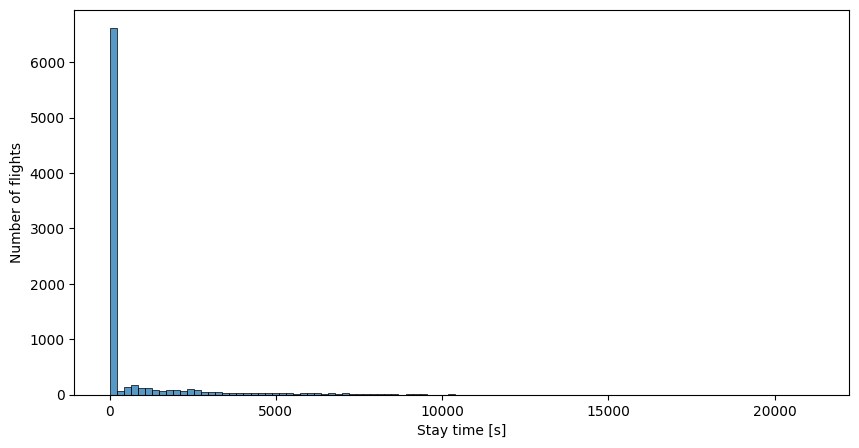

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,5))
sns.histplot(data=hourly_df, x='stay_h', ax=ax, bins=100)
ax.set_xlabel('Stay time [s]')
ax.set_ylabel('Number of flights')

In [16]:
hourly_df.reset_index(inplace=True)
hourly_df

,timestamp_entered_h,count,stay_h
0,2019-01-01 00:00:00+00:00,1,0.222222
1,2019-01-01 01:00:00+00:00,1,0.219444
2,2019-01-01 03:00:00+00:00,7,1.570833
3,2019-01-01 04:00:00+00:00,11,2.052778
4,2019-01-01 05:00:00+00:00,16,2.230556
...,...,...,...
8686,2019-12-30 19:00:00+00:00,56,8.752778
8687,2019-12-30 20:00:00+00:00,64,10.419444
8688,2019-12-30 21:00:00+00:00,39,6.081944
8689,2019-12-30 22:00:00+00:00,17,2.937500


Text(0.5, 1.0, 'Average stay time per weekday')

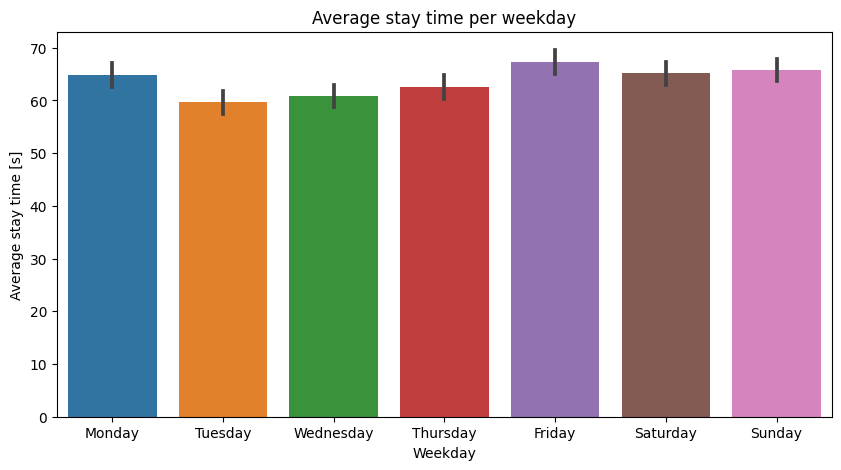

In [18]:
hourly_df['weekday'] = hourly_df['timestamp_entered_h'].dt.day_name()
# get average stay_s per weekday starting with Monday and plot
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(data=hourly_df, x='weekday', y='count', ax=ax, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
ax.set_xlabel('Weekday')
ax.set_ylabel('Average stay time [s]')
ax.set_title('Average stay time per weekday')

In [56]:
hourly_df['month'] = hourly_df['timestamp_entered_h'].dt.month
hourly_df['hour'] = hourly_df['timestamp_entered_h'].dt.hour
# add a column with the day of the year
hourly_df['day_of_year'] = hourly_df['timestamp_entered_h'].dt.dayofyear

mean_count = hourly_df['count'].mean()
median_count = hourly_df['count'].median()
percentile_40 = hourly_df['count'].quantile(0.4)

hourly_df['below_40'] = (hourly_df['count'] < percentile_40).astype(int)
hourly_df['below_mean'] = (hourly_df['count'] < mean_count).astype(int)
hourly_df['below_median'] = (hourly_df['count'] < median_count).astype(int)

hourly_df

,timestamp_entered_h,count,stay_h,weekday,month,hour,day,day_of_year,below_40,below_mean,below_median
0,2019-01-01 00:00:00+00:00,1,0.222222,Tuesday,1,0,1,1,1,1,1
1,2019-01-01 01:00:00+00:00,1,0.219444,Tuesday,1,1,1,1,1,1,1
2,2019-01-01 03:00:00+00:00,7,1.570833,Tuesday,1,3,1,1,1,1,1
3,2019-01-01 04:00:00+00:00,11,2.052778,Tuesday,1,4,1,1,1,1,1
4,2019-01-01 05:00:00+00:00,16,2.230556,Tuesday,1,5,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
8686,2019-12-30 19:00:00+00:00,56,8.752778,Monday,12,19,30,364,1,1,1
8687,2019-12-30 20:00:00+00:00,64,10.419444,Monday,12,20,30,364,0,0,1
8688,2019-12-30 21:00:00+00:00,39,6.081944,Monday,12,21,30,364,1,1,1
8689,2019-12-30 22:00:00+00:00,17,2.937500,Monday,12,22,30,364,1,1,1


In [20]:
mean_count = hourly_df['count'].mean()
median_count = hourly_df['count'].median()
percentile_40 = hourly_df['count'].quantile(0.4)

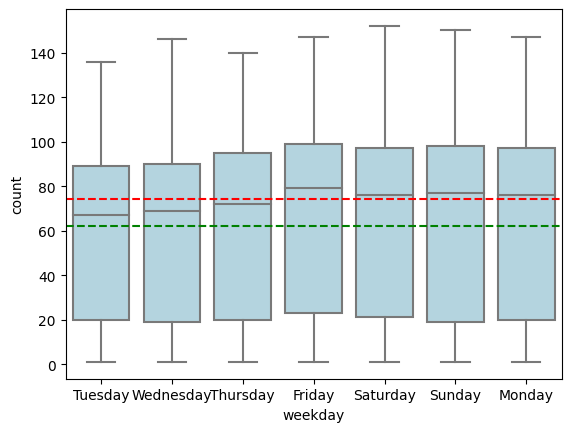

In [26]:
ax = sns.boxplot(x="weekday", y="count", data=hourly_df, showfliers=True, color='lightblue')
ax.axhline(median_count, ls='--', color='red')
ax.axhline(percentile_40, ls='--', color='green')

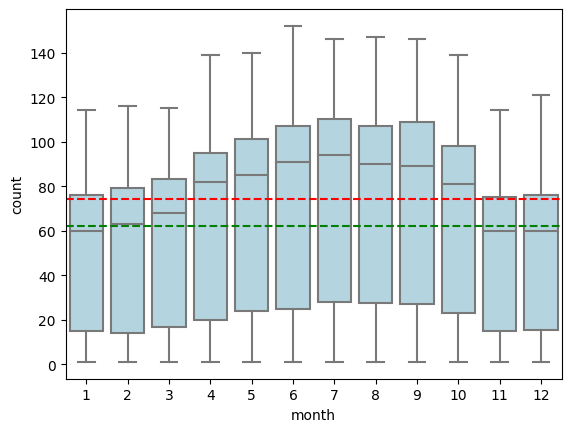

In [25]:
ax = sns.boxplot(x="month", y="count", data=hourly_df, showfliers=True, color='lightblue')
ax.axhline(median_count, ls='--', color='red')
ax.axhline(percentile_40, ls='--', color='green')

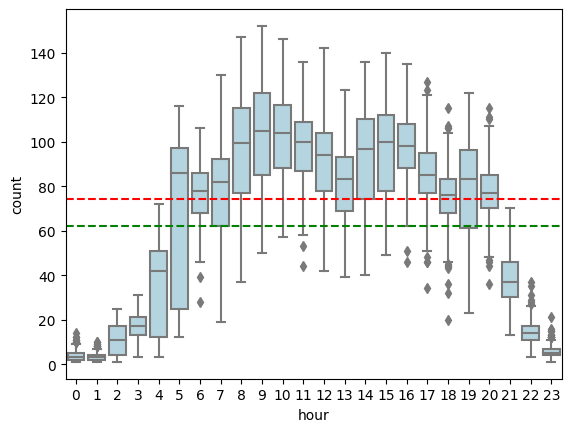

In [24]:
ax = sns.boxplot(x="hour", y="count", data=hourly_df, showfliers=True, color='lightblue')
# add horizontal line for median
ax.axhline(median_count, ls='--', color='red')
ax.axhline(percentile_40, ls='--', color='green')

In [49]:
# make a plotly density plot of the stay time
import plotly.express as px
fig = px.density_heatmap(hourly_df, x="day_of_year", y="hour", z="count", histfunc="avg", nbinsx=365, nbinsy=24, color_continuous_scale="jet")
fig.show()

In [60]:
# make a plotly density plot of the variable 'below_40'
import plotly.express as px
fig = px.density_heatmap(hourly_df, x="day_of_year", y="hour", z="below_median", histfunc="avg", nbinsx=365, nbinsy=24, color_continuous_scale="jet")
fig.show()